In [1]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
# import torchvision.transforms as T
import torchvision.transforms.v2 as T
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torch.utils.data import DataLoader
import torch
import numpy as np
from tqdm import tqdm
from torchvision.transforms.functional import to_tensor
import matplotlib.pyplot as plt
import cv2
import zipfile
import io

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
trainDataPath = r"/content/drive/MyDrive/project/subset2/images/"
trainLblPath = r"/content/drive/MyDrive/project/subset2/labels/"
modelPath = "/content/drive/MyDrive/project/models/mobile/"
projectPath = "/content/drive/MyDrive/project/"
zipimagePath = "/content/drive/MyDrive/project/images2.zip"
ziplabelPath = "/content/drive/MyDrive/project/labels2.zip"
# testDataPath = r"D:/Sem3/CV/Project/DETRAC_Upload/images/test/"
# testLblPath = r"D:/Sem3/CV/Project/DETRAC_Upload/labels/test/"



evalAudioPath = "/content/drive/MyDrive/assigments/vox1/wav/"
evalCsvPath = "/content/drive/MyDrive/assigments/VoxCeleb-Trial-Cleaned.txt"
trainData = "/content/drive/MyDrive/assigments/vox2/aac/"
basePath = "/content/drive/MyDrive/assigments/"
trainCsvPath = basePath+'TrainSep.csv'
testCsvPath = basePath+'TestSep.csv'
beforeFTSim = basePath + "SimilarityBeforeFT.pkl"
afterFTSim = basePath + "SimilarityAfterFT.pkl"
beforeEmb = basePath + "EmbBeforeFT.pkl"
afterEmb = basePath + "EmbAfterFT.pkl"

Mounted at /content/drive


In [9]:
images_zip = zipfile.ZipFile(zipimagePath, 'r')
image_files = [f for f in images_zip.namelist() if f.endswith('.jpg')]
image_files

['images2/Test-Video_mp4-0000_jpg.rf.6a80cf2550c571211b7e0fbdbc7f5fae.jpg',
 'images2/Test-Video_mp4-0001_jpg.rf.54d46f4fb463ae11e36a0f082a2d9083.jpg',
 'images2/Test-Video_mp4-0001_jpg.rf.8f097a975ef116a0cb91ec52140b5a9b.jpg',
 'images2/Test-Video_mp4-0002_jpg.rf.82cd442e2aa486dc351e54bb370158e4.jpg',
 'images2/Test-Video_mp4-0003_jpg.rf.d8b179dee2c7519a08842c2c384d5b2d.jpg',
 'images2/Test-Video_mp4-0004_jpg.rf.80aca1d0999ad73baefaea6d1b1ee63a.jpg',
 'images2/Test-Video_mp4-0005_jpg.rf.3ea8a38a45b789962cb835c63931cf4f.jpg',
 'images2/Test-Video_mp4-0005_jpg.rf.ec44808ce4e62ebd151ec33903810d97.jpg',
 'images2/Test-Video_mp4-0006_jpg.rf.1ad429caffe2da2014f4df9b6b42c809.jpg',
 'images2/Test-Video_mp4-0006_jpg.rf.e91b7b83f7cec3186afdd01009538f1a.jpg',
 'images2/Test-Video_mp4-0007_jpg.rf.098df9159f18124e9f12c0567f886642.jpg',
 'images2/Test-Video_mp4-0008_jpg.rf.761c6e65fed42777dc874802e976b4b4.jpg',
 'images2/Test-Video_mp4-0009_jpg.rf.8b0b4861d06ab8639da8ea746af56f4b.jpg',
 'images2/Te

In [ ]:
annotations_zip = zipfile.ZipFile(ziplabelPath, 'r')
img_name = image_files[0]
annotation_name = img_name.replace('.jpg', '.txt').replace('images','labels')
# image_files = [f for f in images_zip.namelist()]
# annotation_name = os.path.basename(annotation_name)
type(annotations_zip.namelist())

list

In [ ]:
class UADETRACDatasetTXT(Dataset):
    def __init__(self, images_dir, annotations_dir, transforms=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transforms = transforms
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        annotation_path = os.path.join(self.annotations_dir, img_name.replace('.jpg', '.txt'))

        # Load image
        img = Image.open(img_path).convert("RGB")
        img_width, img_height = img.size

        # Load annotations
        boxes = []
        labels = []
        if os.path.exists(annotation_path):
            with open(annotation_path, 'r') as f:
                for line in f.readlines():
                    class_id, x_center, y_center, width, height = map(float, line.split())
                    # Convert from normalized to absolute coordinates
                    x_center *= img_width
                    y_center *= img_height
                    width *= img_width
                    height *= img_height
                    # Convert to (x_min, y_min, x_max, y_max)
                    x_min = x_center - width / 2
                    y_min = y_center - height / 2
                    x_max = x_center + width / 2
                    y_max = y_center + height / 2
                    boxes.append([x_min, y_min, x_max, y_max])
                    labels.append(1)  # Assuming class_id starts from 1

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            img = self.transforms(img)

        return img, target

In [3]:
class UADETRACDatasetTXTZip(Dataset):
    def __init__(self, images_zip_path, annotations_zip_path, transforms=None):
        self.images_zip = zipfile.ZipFile(images_zip_path, 'r')
        self.annotations_zip = zipfile.ZipFile(annotations_zip_path, 'r')
        self.transforms = transforms
        self.image_files = [f for f in self.images_zip.namelist() if f.endswith('.jpg')]
        self.annotation_files = self.annotations_zip.namelist()

        # List all .jpg files in images zip
        self.image_files = [f for f in self.image_files if f.replace('.jpg', '.txt').replace('images2','labels2') in self.annotation_files]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        annotation_name = img_name.replace('.jpg', '.txt').replace('images','labels')

        # Load image from zip as PIL
        img_bytes = self.images_zip.read(img_name)
        img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
        img_width, img_height = img.size

        # Load annotations from zip
        boxes = []
        labels = []
        # if annotation_name in self.annotations_zip.namelist():
        txt_bytes = self.annotations_zip.read(annotation_name)
        for line in txt_bytes.decode().splitlines():
            class_id, x_center, y_center, width, height = map(float, line.split())
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height
            x_min = x_center - width / 2
            y_min = y_center - height / 2
            x_max = x_center + width / 2
            y_max = y_center + height / 2
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(1)  # Adjust if you have multiple classes

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            img = self.transforms(img)

        return img, target

In [5]:
from torch.quantization import get_default_qat_qconfig, prepare_qat, convert
from torch.cuda.amp import autocast, GradScaler
def get_model(num_classes):

    # model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model = fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    # model = ssdlite320_mobilenet_v3_large(pretrained=True)
    return model

def fuse_model(model):
    # Backbone is MobileNetV3 → torchvision already supports layer fusion internally
    if hasattr(model.backbone.body, 'fuse_model'):
        model.backbone.body.fuse_model()
    return model

def prepare_model_for_qat(model):
    model.train()
    model.qconfig = get_default_qat_qconfig('fbgemm')  # for x86/Intel CPUs, use 'qnnpack' for ARM
    prepare_qat(model, inplace=True)
    return model


def collate_fn(batch):
  return tuple(zip(*batch))

# Dataset and Dataloader
# transform = T.Compose([
#     T.RandomPhotometricDistort(),  # brightness, contrast, saturation
#     T.RandomHorizontalFlip(p=0.5),
#     T.RandomIoUCrop(min_scale=0.3),
#     T.ToImage(),
#     T.ToDtype(torch.float32, scale=True),
#     T.Resize((640, 640)),
# ])
transform = T.Compose([T.ToTensor()])
# dataset = UADETRACDatasetTXT(trainDataPath, trainLblPath, transform)
dataset = UADETRACDatasetTXTZip(zipimagePath, ziplabelPath, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=2)  # 1 class + background
# model = fuse_model(model)
# model = prepare_model_for_qat(model)
# customModel = torch.load(f"{modelPath}SSDLiteRCNN_FineTune_epoch_41_Baseline.pth")
# model.load_state_dict(customModel['model_state_dict'])
model.to(device)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# optimizer.load_state_dict(customModel['optimizer_state_dict'])


# Resume from next epoch
# start_epoch = customModel['epoch'] + 2

# Training loop
num_epochs = 20
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for images, targets in tqdm(dataloader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    print(f"Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss:.4f}")
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, modelPath+f"MobRCNNFresh_FineTune_epoch_{epoch}.pth")

100%|██████████| 32/32 [00:45<00:00,  1.43s/it]


Epoch [0/20], Loss: 17.9486


100%|██████████| 32/32 [00:39<00:00,  1.24s/it]


Epoch [1/20], Loss: 18.8856


100%|██████████| 32/32 [00:37<00:00,  1.16s/it]


Epoch [2/20], Loss: 18.4580


100%|██████████| 32/32 [00:36<00:00,  1.15s/it]


Epoch [3/20], Loss: 18.6185


100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


Epoch [4/20], Loss: 18.3026


100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


Epoch [5/20], Loss: 17.8205


100%|██████████| 32/32 [00:35<00:00,  1.11s/it]


Epoch [6/20], Loss: 17.6808


100%|██████████| 32/32 [00:35<00:00,  1.11s/it]


Epoch [7/20], Loss: 17.8182


100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


Epoch [8/20], Loss: 16.9910


100%|██████████| 32/32 [00:35<00:00,  1.09s/it]


Epoch [9/20], Loss: 15.6828


100%|██████████| 32/32 [00:34<00:00,  1.09s/it]


Epoch [10/20], Loss: 15.3730


100%|██████████| 32/32 [00:34<00:00,  1.08s/it]


Epoch [11/20], Loss: 16.3465


100%|██████████| 32/32 [00:34<00:00,  1.08s/it]


Epoch [12/20], Loss: 15.8741


100%|██████████| 32/32 [00:34<00:00,  1.08s/it]


Epoch [13/20], Loss: 15.4544


100%|██████████| 32/32 [00:34<00:00,  1.08s/it]


Epoch [14/20], Loss: 15.8423


100%|██████████| 32/32 [00:34<00:00,  1.07s/it]


Epoch [15/20], Loss: 15.3488


100%|██████████| 32/32 [00:36<00:00,  1.15s/it]


Epoch [16/20], Loss: 15.4480


100%|██████████| 32/32 [00:34<00:00,  1.09s/it]


Epoch [17/20], Loss: 15.6873


100%|██████████| 32/32 [00:34<00:00,  1.08s/it]


Epoch [18/20], Loss: 14.5391


100%|██████████| 32/32 [00:34<00:00,  1.08s/it]


Epoch [19/20], Loss: 14.0184


[[554.8467    117.18274   605.0452    159.54913  ]
 [585.5915    377.68268   742.01685   540.       ]
 [220.77397   198.58609   384.17447   356.86887  ]
 [538.9018     79.95059   583.8926    121.27652  ]
 [266.4655    105.36294   343.20557   154.98254  ]
 [502.4341     58.936275  534.7972     94.30808  ]
 [  3.3514042 259.95764   105.22877   345.93967  ]
 [114.79501   184.36267   209.13995   250.5939   ]
 [728.24207   112.77647   782.99384   152.32716  ]
 [373.08917    56.255363  423.7138     93.597015 ]
 [838.6746     70.47512   893.80005   107.05424  ]
 [ 75.08165   145.78145   165.81837   200.47308  ]
 [210.42717   142.71927   282.05972   185.56241  ]
 [624.56323    33.85061   671.0269     65.66824  ]
 [540.0333     37.269043  589.2023     86.733635 ]
 [797.2927     56.229862  848.98535    88.1377   ]
 [897.81793   247.29004   960.        339.37173  ]
 [168.13788   159.45816   249.16016   210.58714  ]
 [297.06955    71.11357   348.88635   111.26767  ]
 [783.8958     50.046803  834.7

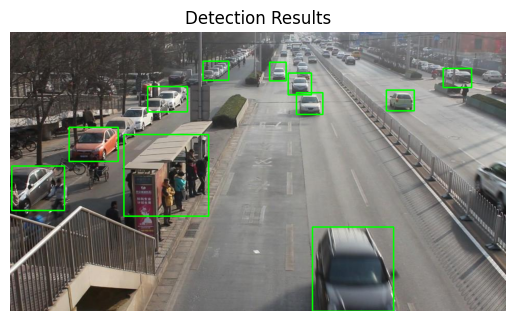

In [ ]:
from torchvision.transforms.functional import to_tensor
import matplotlib.pyplot as plt
import cv2

def evaluate_image(image_path, model, device, threshold=0.8):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    # origImg = img
    # print(img.width, img.height)
    # scale_x = img.width // 480
    # scale_y = img.height //480
    # new_size = (480, 480)
    # img = img.resize(new_size)

    img_tensor = to_tensor(img).to(device)

    with torch.no_grad():
        output = model([img_tensor])[0]

    boxes = output["boxes"].cpu().numpy()
    scores = output["scores"].cpu().numpy()


    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    for box, score in zip(boxes, scores):
        if score > threshold:
            x1, y1, x2, y2 = box.astype(int)
            cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.title("Detection Results")
    plt.axis("off")
    plt.show()

# Usage
evaluate_image("/content/drive/MyDrive/project/MVI_20011_img00001.jpg", model, device)

In [ ]:
def get_model(num_classes):
    # model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model = fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def collate_fn(batch):
  return tuple(zip(*batch))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load model for training
model = get_model(num_classes=2)  # Make sure this matches training config
model = fuse_model(model)
model = prepare_model_for_qat(model)
customModel = torch.load(f"{modelPath}RCNN_FineTune_epoch_9.pth", map_location=torch.device('cpu'))
model.load_state_dict(customModel['model_state_dict'])
model.to(device)

# Load optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer.load_state_dict(customModel['optimizer_state_dict'])

# Resume from next epoch
# start_epoch = customModel['epoch'] + 1

# For inferencing:
# model = get_model(num_classes=2)
# checkpoint = torch.load("fasterrcnn_epoch_5.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# model.to(device)
# model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [ ]:
def compute_iou(boxA, boxB):
    # box format: [x1, y1, x2, y2]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evaluate_model(model, dataloader, device, iou_threshold=0.5, score_threshold=0.5):
    model.eval()
    all_preds = []
    all_gts = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes'].cpu()
                pred_scores = output['scores'].cpu()
                pred_labels = output['labels'].cpu()

                gt_boxes = target['boxes'].cpu()
                gt_labels = target['labels'].cpu()

                # Filter by confidence threshold
                keep = pred_scores >= score_threshold
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]

                matched_gt = set()
                for pb, pl in zip(pred_boxes, pred_labels):
                    found_match = False
                    for i, (gb, gl) in enumerate(zip(gt_boxes, gt_labels)):
                        if i in matched_gt:
                            continue
                        iou = compute_iou(pb.numpy(), gb.numpy())
                        if iou >= iou_threshold and pl == gl:
                            all_preds.append(1)  # TP
                            all_gts.append(1)
                            matched_gt.add(i)
                            found_match = True
                            break
                    if not found_match:
                        all_preds.append(1)  # FP
                        all_gts.append(0)

                for i in range(len(gt_boxes)):
                    if i not in matched_gt:
                        all_preds.append(0)  # FN
                        all_gts.append(1)

    precision = precision_score(all_gts, all_preds)
    recall = recall_score(all_gts, all_preds)
    f1 = f1_score(all_gts, all_preds)
    accuracy = accuracy_score(all_gts, all_preds)

    print(f"📊 Precision: {precision:.4f}")
    print(f"📊 Recall:    {recall:.4f}")
    print(f"📊 F1 Score:  {f1:.4f}")
    print(f"📊 Accuracy:  {accuracy:.4f}")

In [ ]:
transform = T.Compose([T.ToTensor()])
dataset = UADETRACDatasetTXT(trainDataPath, trainLblPath, transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
evaluate_model(model, dataloader, device, iou_threshold=0.5, score_threshold=0.5)

📊 Precision: 0.9397
📊 Recall:    0.9990
📊 F1 Score:  0.9684
📊 Accuracy:  0.9388


In [ ]:
# prompt: I want to create a smaller model which runs much faster. The RCNN model above is very slow, please hare code of how to do knowledge distillation and considerably reduce the student model size but it shot have same accuracy

import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_student_model(num_classes):
    # Define a smaller backbone (MobileNetV3)
    backbone = torchvision.models.mobilenet_v3_small(pretrained=True)
    backbone.classifier = torch.nn.Identity()  # Remove the classification head
    backbone.features[0][0] = torch.nn.Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

    # Define a smaller anchor generator
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))

    # Create the Faster R-CNN model
    model = FasterRCNN(backbone,
                       num_classes=num_classes,
                       rpn_anchor_generator=anchor_generator)
    return model

# Example usage
student_model = create_student_model(num_classes=2)

# Knowledge Distillation
# ... (Implement your knowledge distillation logic here) ...

# You'll need to define a temperature parameter (T) for the softmax function
# Calculate the soft targets from the teacher model (your large RCNN)
# Train the student model to minimize the difference between its predictions and the soft targets

# Example training loop snippet
# ... (In your training loop) ...

# teacher_output = teacher_model(images)  # Get the soft targets from teacher
# student_output = student_model(images)  # Get the predictions from the student

# loss = distillation_loss(student_output, teacher_output, temperature)
# ... (Rest of the training steps) ...


8

In [ ]:
import random

def create_random_pairs(idPathDict, num_pairs):
  pairs = []
  # count = 0
  keyLst = list(idPathDict.keys())
  print(keyLst)
  print(type(keyLst))
  for _ in range(num_pairs):
    pair = random.sample(keyLst, 2)
    pairs.append((idPathDict[pair[0]], idPathDict[pair[1]]))
  return pairs

# Create 100 random pairs from trainDir
random_pairs = create_random_pairs(idDct, 100)

# Print the pairs (optional)
for pair in random_pairs:
  print(pair)


['id00017', 'id00061', 'id00081', 'id00154', 'id00419', 'id00562', 'id00812', 'id00817', 'id00866', 'id00926', 'id01000', 'id01041', 'id01066', 'id01106', 'id01224', 'id01228', 'id01298', 'id01333', 'id01437', 'id01460', 'id01509', 'id01541', 'id01567', 'id01593', 'id01618', 'id01822', 'id01892', 'id01989', 'id02019', 'id02057', 'id02086', 'id02181', 'id02286', 'id02317', 'id02445', 'id02465', 'id02542', 'id02548', 'id02576', 'id02577', 'id02685', 'id02725', 'id02745', 'id03030', 'id03041', 'id03127', 'id03178', 'id03347', 'id03382', 'id03524']
<class 'list'>
('/content/drive/MyDrive/assigments/vox2/aac/id01593/cv1yNAP8Esg/00364.m4a', '/content/drive/MyDrive/assigments/vox2/aac/id00154/BuecddErOwU/00036.m4a')
('/content/drive/MyDrive/assigments/vox2/aac/id02019/D4UJng56XkY/00034.m4a', '/content/drive/MyDrive/assigments/vox2/aac/id00817/WRMSQzOzK-Q/00287.m4a')
('/content/drive/MyDrive/assigments/vox2/aac/id03382/JD9mJTeFLoM/00007.m4a', '/content/drive/MyDrive/assigments/vox2/aac/id02286

In [ ]:
import random
import librosa
import soundfile as sf
import numpy as np

def processAudio(filepath, sample_rate = 16000):
  wav, sr = torchaudio.load(filepath)
  wav = wav.to("cuda" if torch.cuda.is_available() else "cpu")
  if sample_rate != sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=sample_rate)
        wav = resampler(wav)

  return wav.squeeze(0)

def mix_audio_clips(clip1_path, clip2_path, max_len = 48000, output_path = None, snr_db=0):
    # try:
    wav1 = processAudio(clip1_path)
    wav2 = processAudio(clip2_path)

    # rms1 = torch.sqrt(torch.mean(wav1**2))
    # rms2 = torch.sqrt(torch.mean(wav2**2))
    # snr = 10**(snr_db/20)
    # scale_factor = rms1 / (rms2 * snr)
    # wav2 = wav2 * scale_factor

    # len1 = len(y1)
    # len2 = len(y2_scaled)

    if wav1.size(0) > max_len:
      wav1 = wav1[:max_len]
    elif wav1.size(0) < max_len:
        wav1 = torch.cat([wav1, torch.zeros(max_len - wav1.size(0))])

    if wav2.size(0) > max_len:
        wav2 = wav2[:max_len]
    elif wav2.size(0) < max_len:
        wav2 = torch.cat([wav2, torch.zeros(max_len - wav2.size(0))])

    # print(y1.shape, y2_scaled.shape)

    # if len1 > len2:
    #     y2_scaled = np.pad(y2_scaled, (0, len1 - len2), mode='constant')
    # elif len2 > len1:
    #     y1 = np.pad(y1, (0, len2 - len1), mode='constant')


    # print(y1.shape, y2_scaled.shape)

    mixed_audio = wav1 + wav2
    mixed_audio = mixed_audio/torch.max(torch.abs(mixed_audio))
    # sf.write(output_path, mixed_audio, sr1)

    return mixed_audio

    # except Exception as e:
    #     print(f"Error mixing audio: {e}")
    #     return None


In [ ]:
print(random_pairs[0][1])
print(random_pairs[0][0])

/content/drive/MyDrive/assigments/vox2/aac/id00154/BuecddErOwU/00036.m4a
/content/drive/MyDrive/assigments/vox2/aac/id01593/cv1yNAP8Esg/00364.m4a


In [ ]:
# print(random_pairs[1])
x = mix_audio_clips(random_pairs[0][0], random_pairs[0][1])
x = processAudio(random_pairs[0][1])
x

tensor([-0.0216, -0.0199, -0.0234,  ..., -0.0000,  0.0000, -0.0000])